In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import MeanSquaredError

In [2]:
df = pd.read_csv('CGMData/CGM_with_features.csv')
display(df)

,Readings (CGM / BGM),DateTime,Hour,Minute,Eating,Activity Level,Carbohydrate Intake,Insulin Dosage
0,153,2024-03-05 00:03:00,0,3,No,Low,0,2.0
1,161,2024-03-05 00:08:00,0,8,No,Low,0,2.0
2,171,2024-03-05 00:13:00,0,13,No,Low,0,2.0
3,185,2024-03-05 00:18:00,0,18,No,Low,0,2.0
4,198,2024-03-05 00:23:00,0,23,No,Low,0,2.0
...,...,...,...,...,...,...,...,...
3972,400,2024-03-18 23:36:00,23,36,No,Low,0,2.4
3973,400,2024-03-18 23:41:00,23,41,No,Low,0,2.4
3974,400,2024-03-18 23:46:00,23,46,No,Low,0,2.4
3975,400,2024-03-18 23:51:00,23,51,No,Low,0,2.4


In [3]:
# Convert 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Sort the DataFrame by 'DateTime'
df = df.sort_values(by='DateTime')

# Filter the DataFrame to include only the data between start_date and end_date
start_date = '2024-03-17'
end_date = '2024-03-18'
recent_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]
display(recent_data)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(recent_data[['Readings (CGM / BGM)']])


,Readings (CGM / BGM),DateTime,Hour,Minute,Eating,Activity Level,Carbohydrate Intake,Insulin Dosage
3401,275,2024-03-17 00:01:00,0,1,No,Low,0,2.0
3402,265,2024-03-17 00:06:00,0,6,No,Low,0,2.0
3403,262,2024-03-17 00:11:00,0,11,No,Low,0,2.0
3404,263,2024-03-17 00:16:00,0,16,No,Low,0,2.0
3405,269,2024-03-17 00:21:00,0,21,No,Low,0,2.0
...,...,...,...,...,...,...,...,...
3684,153,2024-03-17 23:36:00,23,36,No,Low,0,2.4
3685,146,2024-03-17 23:41:00,23,41,No,Low,0,2.4
3686,138,2024-03-17 23:46:00,23,46,No,Low,0,2.4
3687,125,2024-03-17 23:51:00,23,51,No,Low,0,2.4


In [4]:
# Reshape the data for the LSTM model
def create_dataset(X, y, time_steps=1, future_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - future_steps + 1):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps + future_steps - 1])
    return np.array(Xs), np.array(ys)

In [5]:
time_steps = 10
future_steps_30min = 6  # 30 minutes into the future (assuming each time step is 5 minutes)
future_steps_2hours = 24  # 2 hours into the future (assuming each time step is 5 minutes)

In [10]:
X_30min, y_30min = create_dataset(pd.DataFrame(data_scaled), pd.DataFrame(data_scaled), time_steps, future_steps_30min)

# Split data into training and testing sets
X_train_30min, X_test_30min, y_train_30min, y_test_30min = train_test_split(X_30min, y_30min, test_size=0.2, shuffle=False)

model_30min = Sequential()
model_30min.add(LSTM(units=64, input_shape=(X_train_30min.shape[1], X_train_30min.shape[2])))
model_30min.add(Dense(units=1))

model_30min.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError()])

history_30min = model_30min.fit(X_train_30min, y_train_30min, epochs=100, batch_size=32, validation_split=0.2)
_, mse_30min = model_30min.evaluate(X_test_30min, y_test_30min)

rmse_30min = math.sqrt(mse_30min)

X_pred_30min = np.array([data_scaled[-time_steps:]])
y_pred_30min = model_30min.predict(X_pred_30min)
y_pred_rescaled_30min = scaler.inverse_transform(y_pred_30min.reshape(-1, 1))


Epoch 1/100


c:\Users\zar10\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.1041 - mean_squared_error: 0.1046 - val_loss: 0.0595 - val_mean_squared_error: 0.0616
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0556 - mean_squared_error: 0.0563 - val_loss: 0.0423 - val_mean_squared_error: 0.0492
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0420 - mean_squared_error: 0.0424 - val_loss: 0.0428 - val_mean_squared_error: 0.0496
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0376 - mean_squared_error: 0.0384 - val_loss: 0.0397 - val_mean_squared_error: 0.0471
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0326 - mean_squared_error: 0.0313 - val_loss: 0.0412 - val_mean_squared_error: 0.0485
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0324 - mean_squared_error: 0.0331 - val_loss: 0.0392 - val_mean_squared_error: 0.0468
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0325 - mean_squared_error: 0.0330 - val_loss: 0.0385 - val_mean_squared_error: 0

In [11]:
print(f'Root Mean Squared Error on test set for 30 minutes prediction: {rmse_30min}')
print(f'Predicted blood glucose level 30 minutes into the future: {y_pred_rescaled_30min[0][0]}')

Root Mean Squared Error on test set for 30 minutes prediction: 0.23651888533479157
Predicted blood glucose level 30 minutes into the future: 94.52953338623047


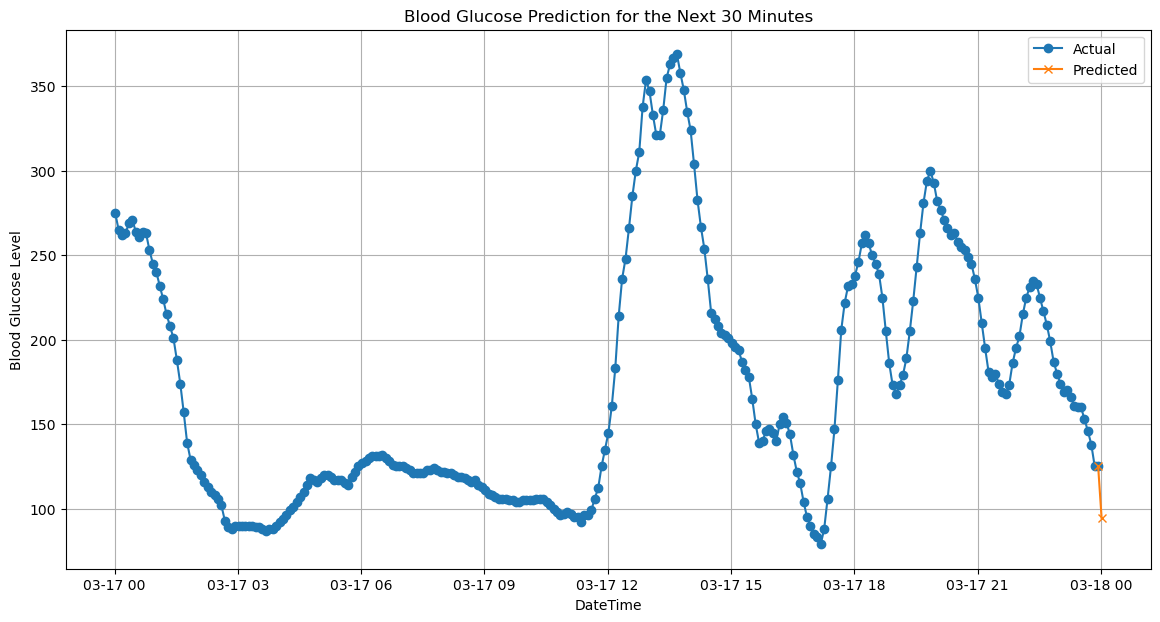

In [12]:
import matplotlib.pyplot as plt

# Plot actual blood glucose values
plt.figure(figsize=(14, 7))
plt.plot(recent_data['DateTime'], recent_data['Readings (CGM / BGM)'], label='Actual', marker='o')

# Plot predicted blood glucose value
pred_datetime = pd.date_range(start=recent_data['DateTime'].iloc[-1], periods=2, freq='5T')[1]
plt.plot([recent_data['DateTime'].iloc[-1], pred_datetime], [recent_data['Readings (CGM / BGM)'].iloc[-1], y_pred_rescaled_30min[0][0]], label='Predicted', marker='x')

plt.title('Blood Glucose Prediction for the Next 30 Minutes')
plt.xlabel('DateTime')
plt.ylabel('Blood Glucose Level')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
X_2hours, y_2hours = create_dataset(pd.DataFrame(data_scaled), pd.DataFrame(data_scaled), time_steps, future_steps_2hours)

X_train_2hours, X_test_2hours, y_train_2hours, y_test_2hours = train_test_split(X_2hours, y_2hours, test_size=0.2, shuffle=False)

model_2hours = Sequential()
model_2hours.add(LSTM(units=64, input_shape=(X_train_2hours.shape[1], X_train_2hours.shape[2])))
model_2hours.add(Dense(units=1))

model_2hours.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError()])

history_2hours = model_2hours.fit(X_train_2hours, y_train_2hours, epochs=100, batch_size=32, validation_split=0.2)

_, mse_2hours = model_2hours.evaluate(X_test_2hours, y_test_2hours)

rmse_2hours = math.sqrt(mse_2hours)

X_pred_2hours = np.array([data_scaled[-time_steps:]])
y_pred_2hours = model_2hours.predict(X_pred_2hours)
y_pred_rescaled_2hours = scaler.inverse_transform(y_pred_2hours.reshape(-1, 1))

Epoch 1/100


c:\Users\zar10\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.1242 - mean_squared_error: 0.1288 - val_loss: 0.1273 - val_mean_squared_error: 0.1064
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0917 - mean_squared_error: 0.0942 - val_loss: 0.0947 - val_mean_squared_error: 0.0853
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0717 - mean_squared_error: 0.0681 - val_loss: 0.0867 - val_mean_squared_error: 0.0773
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0781 - mean_squared_error: 0.0810 - val_loss: 0.0751 - val_mean_squared_error: 0.0683
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0687 - mean_squared_error: 0.0717 - val_loss: 0.0668 - val_mean_squared_error: 0.0619
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0686 - mean_squared_error: 0.0670 - val_loss: 0.0611 - val_mean_squared_error: 0.0574
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0739 - mean_squared_error: 0.0723 - val_loss: 0.0469 - val_mean_squared_error: 

In [28]:
print(f'Root Mean Squared Error on test set for 2 hours prediction: {rmse_2hours}')
print(f'Predicted blood glucose level 2 hours into the future: {y_pred_rescaled_2hours[0][0]}')

Root Mean Squared Error on test set for 2 hours prediction: 0.33645635280478947
Predicted blood glucose level 2 hours into the future: 82.92009735107422


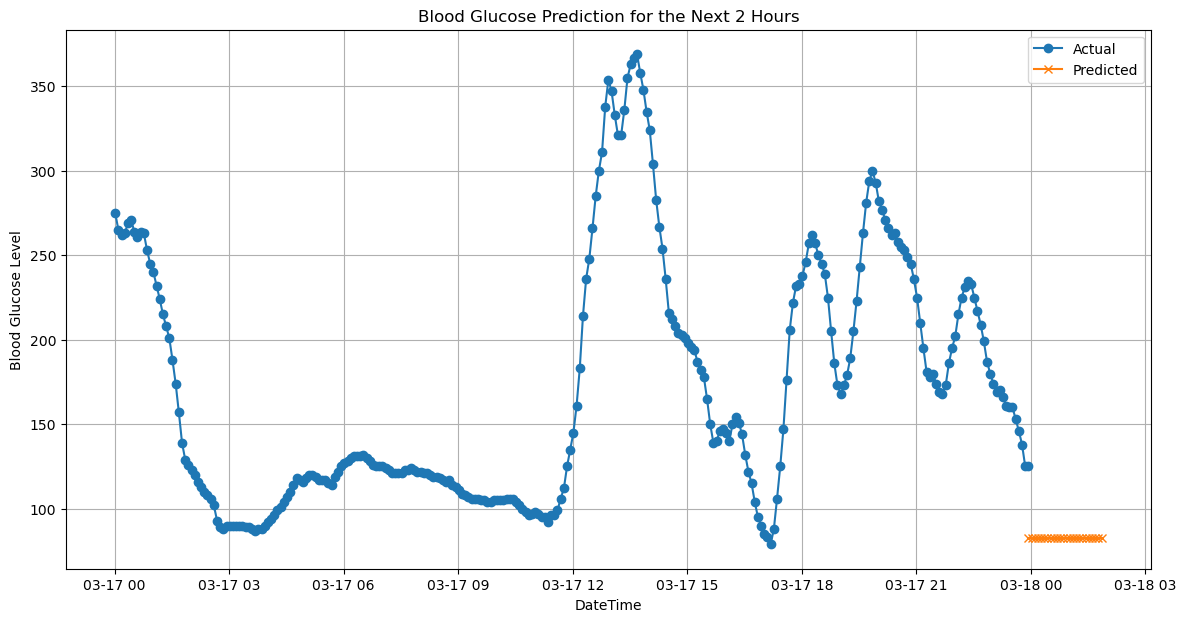

In [29]:
import numpy as np

# Plot actual blood glucose values
plt.figure(figsize=(14, 7))
plt.plot(recent_data['DateTime'], recent_data['Readings (CGM / BGM)'], label='Actual', marker='o')

# Plot predicted blood glucose values
pred_dates_2hours_adjusted = pd.date_range(start=recent_data['DateTime'].iloc[-1], periods=future_steps_2hours+1, freq='5T')
pred_dates_2hours = pred_dates_2hours_adjusted[:-1]  # Remove the last timestamp
plt.plot(pred_dates_2hours, np.repeat(y_pred_rescaled_2hours[0][0], future_steps_2hours), label='Predicted', marker='x')

plt.title('Blood Glucose Prediction for the Next 2 Hours')
plt.xlabel('DateTime')
plt.ylabel('Blood Glucose Level')
plt.legend()
plt.grid(True)
plt.show()